In [1]:
import sys
import os
import urllib.request  
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Gromacs_py import
from gromacs_py import gmx

from os_command_py import os_command

In [3]:
from gromacs_py.test.datafiles import PDB_1D30

In [3]:
%cd /home/murail/Documents/Code/gromacs_py/docs/notebook/
%matplotlib notebook

/home/murail/Documents/Code/gromacs_py/docs/notebook


In [4]:
tmp_path = 'test_free'

In [7]:
from gromacs_py.free_ener import FreeEner

dna_free = FreeEner('DAP', f'{tmp_path}/1D30_solv')

In [8]:
dna_free.prepare_complex_pdb(
        PDB_1D30, 'NC(=N)c1ccc(cc1)c2[nH]c3cc(ccc3c2)C(N)=N')

pdb2pqr_cli --ff AMBER --ffout AMBER --chain --ph-calc-method=propka --with-ph=7.00 tmp_pdb2pqr.pdb 00_DAP.pqr
acpype -i DAP_h_unique.pdb -b DAP -c bcc -a gaff -o gmx -n 0
gmx pdb2gmx -f 01_DAP_good_his.pdb -o DAP_pdb2gmx.pdb -p DAP_pdb2gmx.top -i DAP_posre.itp -water tip3p -ff amber99sb-ildn -ignh -vsite none
gmx editconf -f test_free/1D30_solv/complex_top/DAP_pdb2gmx_mol.pdb -o test_free/1D30_solv/complex_top/DAP_pdb2gmx_mol_box.pdb -bt dodecahedron -d 1.1
gmx grompp -f ../../../../../gromacs_py/gmx/template/mini.mdp -c DAP_water.pdb -r DAP_water.pdb -p DAP_water_ion.top -po out_mini.mdp -o genion_DAP_water_ion.tpr -maxwarn 3
gmx genion -s genion_DAP_water_ion.tpr -p DAP_water_ion.top -o DAP_water_ion.gro -np 22 -pname NA -nn 0 -nname CL


In [9]:
dna_free.equilibrate_complex(em_steps=100, HA_time=0.001,
                             CA_time=0.002, CA_LOW_time=0.02,
                             dt=0.002, dt_HA=0.001, temp=300,
                             receptor_grp='DNA',
                             short_steps=500)

gmx grompp -f Init_em_DAP.mdp -c ../sys_top/DAP_water_ion.gro -r ../sys_top/DAP_water_ion.gro -p ../sys_top/DAP_water_ion.top -po out_Init_em_DAP.mdp -o Init_em_DAP.tpr -maxwarn 3
gmx mdrun -s Init_em_DAP.tpr -deffnm Init_em_DAP -nt 0 -ntmpi 0 -nsteps -2 -nocopyright



gmx grompp -f DAP.mdp -c Init_em_DAP.gro -r Init_em_DAP.gro -p ../sys_top/DAP_water_ion.top -po out_DAP.mdp -o DAP.tpr -maxwarn 3
gmx mdrun -s DAP.tpr -deffnm DAP -nt 0 -ntmpi 0 -nsteps -2 -nocopyright



gmx trjconv -f test_free/1D30_solv/prot_em/DAP.trr -o test_free/1D30_solv/prot_em/DAP_compact.xtc -s test_free/1D30_solv/prot_em/DAP.tpr -ur compact -pbc mol -center yes
gmx grompp -f equi_HA_short_DAP.mdp -c ../prot_em/DAP.gro -r ../prot_em/DAP.gro -p ../sys_top/DAP_water_ion.top -po out_equi_HA_short_DAP.mdp -o equi_HA_short_DAP.tpr -maxwarn 3
gmx mdrun -s equi_HA_short_DAP.tpr -deffnm equi_HA_short_DAP -nt 0 -ntmpi 0 -nsteps -2 -nocopyright



gmx make_ndx -f test_free/1D30_solv/sys_short_equi/equi_HA_short_DAP.gro -o test_free/1D30_solv/sys_short_equi/equi_HA_short_DAP.ndx
gmx make_ndx -f test_free/1D30_solv/sys_short_equi/equi_HA_short_DAP.gro -o test_free/1D30_solv/sys_short_equi/equi_HA_short_DAP.ndx
{'tc-grps': 'DNA_DAP Water_and_ions'}
gmx grompp -f equi_HA_DAP.mdp -c ../../sys_short_equi/equi_HA_short_DAP.gro -r ../../prot_em/DAP.gro -p ../../sys_top/DAP_water_ion.top -po out_equi_HA_DAP.mdp -o equi_HA_DAP.tpr -maxwarn 3 -n ../../sys_short_equi/equi_HA_short_DAP.ndx
gmx mdrun -s equi_HA_DAP.tpr -deffnm equi_HA_DAP -nt 0 -ntmpi 0 -nsteps -2 -nocopyright



gmx grompp -f equi_CA_DAP.mdp -c ../00_equi_HA/equi_HA_DAP.gro -r ../../prot_em/DAP.gro -p ../../sys_top/DAP_water_ion.top -po out_equi_CA_DAP.mdp -o equi_CA_DAP.tpr -maxwarn 3 -n ../../sys_short_equi/equi_HA_short_DAP.ndx
gmx mdrun -s equi_CA_DAP.tpr -deffnm equi_CA_DAP -nt 0 -ntmpi 0 -nsteps -2 -nocopyright



gmx grompp -f equi_CA_LOW_DAP.mdp -c ../01_equi_CA/equi_CA_DAP.gro -r ../../prot_em/DAP.gro -p ../../sys_top/DAP_water_ion.top -po out_equi_CA_LOW_DAP.mdp -o equi_CA_LOW_DAP.tpr -maxwarn 3 -n ../../sys_short_equi/equi_HA_short_DAP.ndx
gmx mdrun -s equi_CA_LOW_DAP.tpr -deffnm equi_CA_LOW_DAP -nt 0 -ntmpi 0 -nsteps -2 -nocopyright


In [10]:
dna_free.compute_add_intermol_from_traj(ref_coor=None, rec_group='DNA')

gmx trjconv -f test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP.xtc -o test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP_compact.xtc -s test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP.tpr -ur compact -pbc mol -center yes -n test_free/1D30_solv/sys_short_equi/equi_HA_short_DAP.ndx
gmx trjconv -f test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP_compact.xtc -o test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP_compact_compact.xtc -s test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP.tpr -ur compact -pbc none -fit rot+trans -n test_free/1D30_solv/sys_short_equi/equi_HA_short_DAP.ndx
gmx rmsf -s test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP.tpr -f test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP_compact_compact.xtc -n test_free/1D30_solv/sys_short_equi/equi_HA_short_DAP.ndx -o tmp_rmsf.xvg -fit no -res no
Ligand atom indexes : [778, 777, 772]
gmx rmsf -s test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA

In [11]:
dg_rest_water = dna_free.get_water_restr()
print(dg_rest_water)

7.759042019939441


gmx distance -n tmp.ndx -f test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP_compact_compact.xtc -s test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP.tpr -oall tmp_dist.xvg
0.34 0.39
gmx angle -n tmp.ndx -f test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP_compact_compact.xtc -ov tmp_angle.xvg -od tmp_angdist.xvg -type angle -all
gmx angle -n tmp.ndx -f test_free/1D30_solv/sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP_compact_compact.xtc -ov tmp_angle.xvg -od tmp_angdist.xvg -type dihedral -all


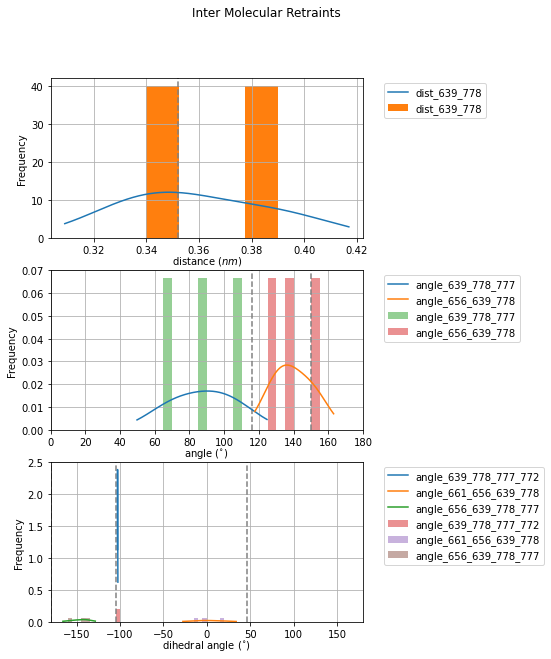

In [12]:
dna_free.plot_intermol_restr()

In [14]:
delta_restr = 0.5
restr_list = np.arange(0, 1 + delta_restr, delta_restr)
delta_coul = 0.5
coul_list = np.arange(0, 1 + delta_coul, delta_coul)
vdw_coul = 0.5
vdw_list = np.arange(0, 1 + vdw_coul, vdw_coul)


In [15]:
dna_free.run(lambda_restr_list=restr_list,
                 lambda_coul_list=coul_list,
                 lambda_vdw_list=vdw_list,
                 em_steps=50, nvt_time=0.05, npt_time=0.05, prod_time=0.25,
                 temp_groups='System')

WARNING !!! ADDING unusual parameter : "calc_lambda_neighbors"in the mdp file em_DAP_vdwq_00.mdp


gmx grompp -f em_DAP_vdwq_00.mdp -c ../../sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP.gro -r ../../sys_equi/02_equi_CA_LOW/equi_CA_LOW_DAP.gro -p ../../sys_top/DAP_water_ion_rest.top -po out_em_DAP_vdwq_00.mdp -o em_DAP_vdwq_00.tpr -maxwarn 1 -n ../../sys_short_equi/equi_HA_short_DAP.ndx
gmx mdrun -s em_DAP_vdwq_00.tpr -deffnm em_DAP_vdwq_00 -nt 0 -ntmpi 0 -nsteps -2 -nocopyright



The following command could not be executed correctly :
gmx mdrun -s em_DAP_vdwq_00.tpr -deffnm em_DAP_vdwq_00 -nt 0 -ntmpi 0 -nsteps -2 -nocopyright

                      :-) GROMACS - gmx mdrun, 2021.1 (-:

Executable:   /home/murail/Documents/Software/local-gromacs-2021.1/bin/gmx
Data prefix:  /home/murail/Documents/Software/local-gromacs-2021.1
Working dir:  /home/murail/Documents/Code/gromacs_py/docs/notebook/test_free/1D30_solv/free_ener_run/00_em
Command line:
  gmx mdrun -s em_DAP_vdwq_00.tpr -deffnm em_DAP_vdwq_00 -nt 0 -ntmpi 0 -nsteps -2 -nocopyright



Reading file em_DAP_vdwq_00.tpr, VERSION 2021.1 (single precision)
Using 1 MPI thread
Using 12 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+01
   Number of steps    =           50

-------------------------------------------------------
Program:     gmx mdrun, version 2021.1
Source file: src/gromacs/gmxlib/nonbonded/nb_free_energy.cpp (line 854)

Fatal error:
There are 9 perturbed non-bonded pair i

RuntimeError: Following Command Fails : /home/murail/Documents/Software/local-gromacs-2021.1/bin/gmx mdrun -s em_DAP_vdwq_00.tpr -deffnm em_DAP_vdwq_00 -nt 0 -ntmpi 0 -nsteps -2 -nocopyright

In [6]:
view = cyclic_pep.view_coor()
view.add_representation(repr_type='licorice', selection='protein')
view

NGLWidget()

In [7]:
#Basic usage :
cyclic_pep.cyclic_peptide_top(out_folder=os.path.join(TEST_OUT,'cyclic/top'), ff='amber99sb-ildn')

gmx pdb2gmx -f ../../../../../gromacs_py/test_files/5vav.pdb -o no_cyclic_5vav_pdb2gmx.pdb -p no_cyclic_5vav_pdb2gmx.top -i no_cyclic_5vav_posre.itp -water tip3p -ff amber99sb-ildn -ignh -ter -vsite none


In [8]:
view = cyclic_pep.view_coor()
view.add_representation(repr_type='licorice', selection='protein')
view

NGLWidget()

In [9]:
cyclic_top = gmx.TopSys(cyclic_pep.top_file)
print(cyclic_top.charge())

0.0


In [10]:
#cyclic_pep.em(out_folder=TEST_OUT+'/cyclic_charmm/em/', nsteps=100, create_box_flag=True)
cyclic_pep.em(out_folder=TEST_OUT+'/cyclic/em/', nsteps=100, create_box_flag=True)

gmx editconf -f tmp/cyclic/top/no_cyclic_5vav_pdb2gmx.pdb -o tmp/cyclic/top/no_cyclic_5vav_pdb2gmx_box.pdb -bt dodecahedron -d 1.0
gmx grompp -f 5vav.mdp -c ../top/no_cyclic_5vav_pdb2gmx_box.pdb -r ../top/no_cyclic_5vav_pdb2gmx_box.pdb -p ../top/no_cyclic_5vav_pdb2gmx.top -po out_5vav.mdp -o 5vav.tpr -maxwarn 1
gmx mdrun -s 5vav.tpr -deffnm 5vav -nt 0 -ntmpi 0 -nsteps -2 -nocopyright


In [12]:
view = cyclic_pep.view_traj()
view.add_representation(repr_type='licorice', selection='protein')
view

NGLWidget()

In [14]:
cyclic_top = gmx.TopSys(cyclic_pep.top_file)
cyclic_top.prot_res_num()

14